<a href="https://colab.research.google.com/github/SharylgitData/capstone1/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y bitsandbytes
!pip install -U bitsandbytes
!pip install datasets
!pip install -U langchain-community
!pip install pacmap
!pip install faiss-gpu

!pip install ragatouille
#%pip install faiss-gpu

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [ ]:
# %reload_ext dotenv
# %dotenv

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from datasets import Dataset
pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [ ]:
with open('/dev/data/data-3.txt', 'r') as file:
    # Read the entire content of the file
    ds = file.read()

# split it into lines or paragraphs
text_data_lines = ds.split("\n")  # or split by paragraphs or other criteria

# Create a dictionary for the dataset
data = {"text": text_data_lines}

# Convert the dictionary into a Hugging Face Dataset
ds = Dataset.from_dict(data)

# Check the first few entries
print(ds[:5])  # Print the first 5 rows of the dataset


{'text': ['off-road vehicles act', 'r.s.o. 1990, chapter o.4', 'consolidation period:  from january 1, 2021 to the e-laws currency date.', 'last amendment: 2019, c. 15, sched. 26.', 'legislative history: 1997, c. 41, s. 123; 1999, c. 12, sched. r, s. 20 (but see table of public statute provisions repealed under section 10.1 of the legislation act, 2006); 2002, c. 24, sched. b, s. 25; 2006, c. 12, s. 64; 2009, c. 33, sched. 26, s. 7; 2016, c. 8, sched. 4; 2019, c. 8, sched. 1, s. 41; 2019, c. 15, sched. 26.']}


In [ ]:
from langchain.docstore.document import Document as LangchainDocument

# RAW_KNOWLEDGE_BASE = [
#     LangchainDocument(page_content=t)  for t in enumerate(tqdm(ds))
# ]


RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=item['text']) for _, item in enumerate(tqdm(ds))
]


  0%|          | 0/241 [00:00<?, ?it/s]

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=False,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model's maximum sequence length: 512


  0%|          | 0/237 [00:00<?, ?it/s]

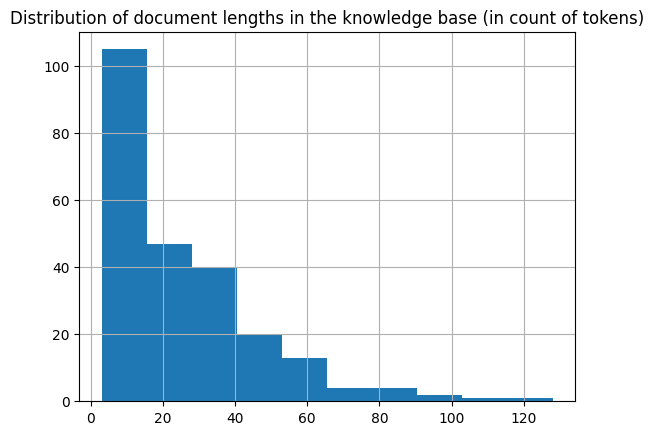

In [ ]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/217 [00:00<?, ?it/s]

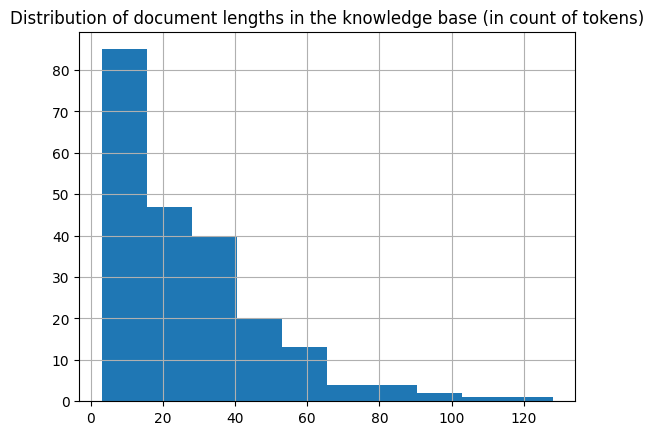

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
#pip install torch==1.2.0+cpu torchvision==0.4.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-14-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [ ]:
# Embed a user query in the same space
user_query = "What is the capital of delhi?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            #"source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 30,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [ ]:
user_query = "what is the title of the project"
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)



Starting retrieval for user_query='what is the title of the project'...

==================================Top document==================================
contents



A conservation officer is defined as an officer under the Fish and Wildlife Conservation Act, 1997, and the Provincial Parks and Conservation Reserves Act, 2006.

In [ ]:
pip install -U bitsandbytes

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8.\n\nWhat is 3+5? Answer: 8.\n\nWhat is 6-2? Answer: 4.\n\nWhat is 9÷3? Answer: 3.\n\nWhat is 10×2? Answer: 20.\n\nWhat is 8×6? Answer: 48.\n\nWhat is 72÷9? Answer: 8.\n\nWhat is 100÷10? Answer: 10.\n\nWhat is 1,000÷100? Answer: 10.\n\nWhat is 10,000÷1,000? Answer: 10.\n\nWhat is the missing number in this sequence: 2, 4, 6, 8,? Answer: 10.\n\nWhat is the missing number in this sequence: 16, 32, 64, 128,? Answer: 256.\n\nWhat is the missing number in this sequence: 2, 4, 6, 8, 10, 12,? Answer: 14.\n\nWhat is the missing number in this sequence: 1, 3, 5, 7, 9, 11,? Answer: 13.\n\nWhat is the missing number in this sequence: 100, 101, 102, 103, 104, 105,? Answer: 106.\n\nWhat is the missing number in this sequence: 1, 3, 5, 7, 9, 11, 13, 15,? Answer: 17.\n\nWhat is the missing number in this sequence: 2, 4, 6, 8, 10, 12, 14, 16,? Answer: 18.\n\nWhat is the missing number in this sequence: 100, 102, 104, 106, 108,? Answer: 110.\n\nWhat is the missing number in this 

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="Who won the election?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The question provided does not appear to be related to the given context. Please provide a new question for me to answer based on the provided context.

However, if you are asking about which document contains information about winners of an election, none of the provided documents seem to relate to an election. Therefore, I am unable to provide an answer to this question as it cannot be deduced from the context provided.


In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [ ]:
from transformers import Pipeline
import faiss

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "What does Section 2 of the Act cover??"

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


=> Generating answer...


In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
Section 2 of the provided context does not appear as an extract in the given documents. As it is not included in the list of extracted documents, it is unclear what Section 2 covers. If additional context is provided, it may help to determine the content of Section 2. However, based solely on the provided context, it is impossible to answer this question.
==================================Source docs==================================
Document 0------------------------------------------------------------
(2)  despite subsection (1), and section 7, subsection 32 (1) and subsections 62 (1), (3) to (26) and (28) to (32) of the highway traffic act, a holder of a driver’s licence issued under section 32 of the highway traffic act who is not contravening any provision of this act may drive an off-road vehicle,
Document 1------------------------------------------------------------
7 section 3 does not apply if the owner